In [1]:
# Load packages
import pandas as pd
import numpy as np
import cv2 as cv

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from joblib import dump
from joblib import load

In [3]:
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

In [5]:
import time

In [6]:
import pickle

In [7]:
import joblib


In [8]:
import os


## Linear SVC on Gray Data + HOG + SumXY

**Load train data**

In [12]:
train_df = pd.read_csv('gray_small_train_set.csv')



In [13]:
train_hog_df = pd.read_csv('hog_fd_train.csv')

In [14]:
sumy_df =  pd.read_csv('histy_train.csv')

In [15]:
sumx_df =  pd.read_csv('histx_train.csv')

In [16]:
train_df.shape, train_hog_df.shape, sumy_df.shape, sumx_df.shape



((3377, 1201), (3377, 1729), (3377, 41), (3377, 31))

In [17]:
train_df.shape

(3377, 1201)

**Create train data for fitting LinearSVC**

In [18]:
train_data = pd.concat([train_df, train_hog_df.iloc[:,1:], sumy_df.iloc[:,1:], sumx_df.iloc[:,1:]], axis=1)

In [19]:
train_data.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,sum_x_20,sum_x_21,sum_x_22,sum_x_23,sum_x_24,sum_x_25,sum_x_26,sum_x_27,sum_x_28,sum_x_29
0,0,255,255,255,255,254,241,236,234,220,...,2750,7250,10000,10000,10000,10000,10000,10000,10000,10000
1,2,255,255,255,255,255,255,255,255,255,...,6750,9250,10000,10000,10000,10000,10000,10000,10000,10000
2,2,255,255,255,255,255,255,255,255,255,...,8000,8500,10000,10000,10000,10000,10000,10000,10000,10000


In [20]:
train_data.shape

(3377, 2999)

In [21]:
x_train = train_data.iloc[:, 1:].values.astype(np.float32)
y_train =train_data['label'].values

In [22]:
x_train.shape, train_data.shape

((3377, 2998), (3377, 2999))

**Load test data**

In [23]:
test_df = pd.read_csv('gray_small_test_set.csv')



In [24]:
test_df.shape

(965, 1201)

In [25]:
test_hog_df = pd.read_csv('hog_fd_test.csv')

In [26]:
sumy_test_df =  pd.read_csv('histy_test.csv')

In [27]:
sumx_test_df =  pd.read_csv('histx_test.csv')

**creating test data**

In [28]:
test_data = pd.concat([test_df, test_hog_df.iloc[:,1:], sumy_test_df.iloc[:,1:], sumx_test_df.iloc[:,1:]], axis=1)



In [29]:
 test_data.shape

(965, 2999)

In [30]:
x_test = test_data.iloc[:, 1:].values.astype(np.float32)
y_test =  test_data['label'].values

**Fit the data**2:33

7:53, took 2 minutes

In [29]:
x_train.shape, x_test.shape

((3377, 2998), (965, 2998))

In [49]:
# Classification with a linear SVM
percent=100
start_time = time.time()
svc = LinearSVC(dual=False, random_state=123)
params_grid = {"C": [10 ** k for k in range(-5, 4)]}
clf = GridSearchCV(svc, params_grid)
clf.fit(x_train, y_train)
print('percent complete: ',percent, end =" - %s seconds -\n" % \
              (time.time() - start_time), flush=False)



percent complete:  100 - 344.2005350589752 seconds -


**performance went down, from 1 minute to 5 minutes**

**Accuracy Score on Test data**

In [50]:
print("Accuracy on the test set with gray plus HOG, and Sum of X and Y vector data: {:.3f}".format(clf.score(x_test, y_test)))

Accuracy on the test set with gray plus HOG, and Sum of X and Y vector data: 0.991


In [51]:
# Print the best parameters
print("Best parameters: ", clf.best_params_)

Best parameters:  {'C': 0.001}


**hyperparameter search**

In [54]:
# Test each model
percent=0
start_time = time.time()
print('percent complete: ',percent, end =" - %s seconds -\n" % \
              (time.time() - start_time), flush=False)
accuracy_results = []
for i in range(len(clf.cv_results_['params'])):
    print("\nModel parameters: ", clf.cv_results_['params'][i])
    
    model = clf.estimator.set_params(**clf.cv_results_['params'][i])
    model.fit(x_train, y_train)
    
    # Predict on validation data
    y_pred = model.predict(x_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy on test data: ", accuracy)
    
    # Append the accuracy to the results list
    accuracy_results.append((clf.cv_results_['params'][i], accuracy))
    
    # Save the model
    dump(model, f'linear_svc_gshh_C_{clf.cv_results_["params"][i]["C"]}.joblib') 
    percent = round(((i+1)/len(clf.cv_results_['params']))*100,2)
    print('percent complete: ',percent, end =" - %s seconds -\n" % \
              (time.time() - start_time), flush=True)
    
print('percent complete: ',percent, end =" - %s seconds -\n" % \
              (time.time() - start_time), flush=False)

# Convert the results to a DataFrame for pretty printing
df = pd.DataFrame(accuracy_results, columns=['Model', 'Accuracy'])
print(df) 

percent complete:  0 - 0.0 seconds -

Model parameters:  {'C': 1e-05}
Accuracy on test data:  0.9906735751295337
percent complete:  11.11 - 6.724075078964233 seconds -

Model parameters:  {'C': 0.0001}
Accuracy on test data:  0.9906735751295337
percent complete:  22.22 - 15.451654434204102 seconds -

Model parameters:  {'C': 0.001}
Accuracy on test data:  0.9906735751295337
percent complete:  33.33 - 24.91872477531433 seconds -

Model parameters:  {'C': 0.01}
Accuracy on test data:  0.9906735751295337
percent complete:  44.44 - 34.62979984283447 seconds -

Model parameters:  {'C': 0.1}
Accuracy on test data:  0.9906735751295337
percent complete:  55.56 - 42.88117718696594 seconds -

Model parameters:  {'C': 1}
Accuracy on test data:  0.9906735751295337
percent complete:  66.67 - 50.30094599723816 seconds -

Model parameters:  {'C': 10}
Accuracy on test data:  0.9906735751295337
percent complete:  77.78 - 57.47549319267273 seconds -

Model parameters:  {'C': 100}
Accuracy on test data: 

**For later use**

In [55]:


# Save to file
with open('linear_svc_gray_small_histxy.pkl', 'wb') as f:
    pickle.dump(clf, f)


In [56]:
# Load from file
with open('linear_svc_gray_small_histxy.pkl', 'rb') as f:
    clf_graw_loaded = pickle.load(f)

### Check accuracy per category 
Use test set

label_key = {
    "Pants": 0, 
    "Tshirts":1,
    "Watches":2, 
    "Casual Shoes":3 
 
}

**want subset of of x_test and y_test where y_test = {Pants, Tshrts, Watches, Casual Shoes}**
**get index**
recall 0 is float int64

In [66]:
decipher_key = {
    0:"Pants",
    1:"Tshirts",
    2:"Watches",
    3:"Casual Shoes"
 
}

In [36]:
x_tlist =[]
y_tlist = []
tlabel =[]
for i in range(4):
    indices = np.where(y_test == i)[0]
    y_tlist.append(y_test[indices])
    x_tlist.append(x_test[indices])
    tlabel.append(decipher_key[i])
    
y_tlist[0].shape, y_tlist[0][0:3]
    

((239,), array([0, 0, 0], dtype=int64))

In [37]:
for i in range(4):
    print("Accuracy on the",tlabel[i]," test set with grayscale image: {:.3f}".\
          format(clf_graw_loaded.score(x_tlist[i], y_tlist[i])))

Accuracy on the Pants  test set with grayscale image: 0.987
Accuracy on the Tshirts  test set with grayscale image: 0.991
Accuracy on the Watches  test set with grayscale image: 0.988
Accuracy on the Casual Shoes  test set with grayscale image: 0.996


**The Tshirt accuracy improved by 0.02 points!**

**Generate Confusion Matrix For Each Result**

In [38]:
from sklearn.metrics import confusion_matrix
#x_tlist[i]
#y_tlist[i]

# Use the fitted model to make predictions on the same data used for fitting
y_pred = clf_graw_loaded.predict(x_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#print(cm)


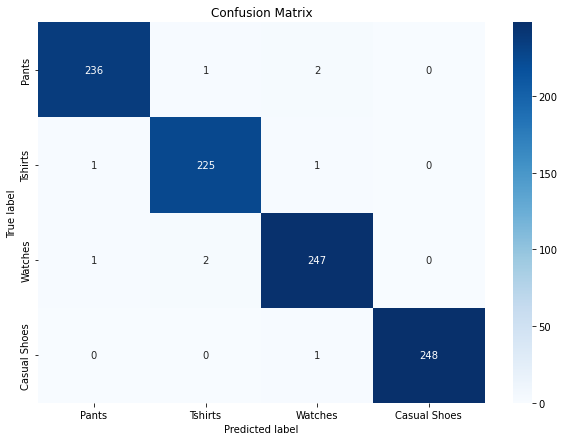

In [39]:
# Create a heatmap
# Create a list of labels
labels = [decipher_key[i] for i in range(4)]
plt.figure(figsize=(10,7))
#sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add labels to the plot
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

**Including the HOG vector, allows us to reclassify an image from Watches to Tshirts (6 to 5) increasing the Tshirt TP count from 220 to 221**

**Pull Up Examples of False Positives (Tshirts)**

In [40]:
# Assuming y_true is your list of true labels and y_pred is your list of predicted labels
# And X_data is your original dataset

misclassified_indexes = []

for i in range(len(y_test)):
    # If true label is 'Tshirts' (which corresponds to 1)
    # and predicted label is 'Casual Shoes' (which corresponds to 3)
    if (y_test[i] == 1) and (y_pred[i] == 2):
        misclassified_indexes.append(i)

# Now, misclassified_indexes contains the indexes of all misclassified examples
# You can use it to get the corresponding data from X_data
#misclassified_data = x_test[misclassified_indexes]

In [41]:
misclassified_indexes

[851]

In [42]:
test_df = pd.read_csv('output_rgb_test.csv')

#test_img = test_df.iloc[:, 1:].values.astype(np.float32)
test_img = test_df.iloc[:, 1:].values.astype(np.uint8)

test_label = test_df['label'].values

#img_rgb = (img_rgb * 255).astype(np.uint8) before axarr.imshow(img_rgb)

<Figure size 2016x2016 with 0 Axes>

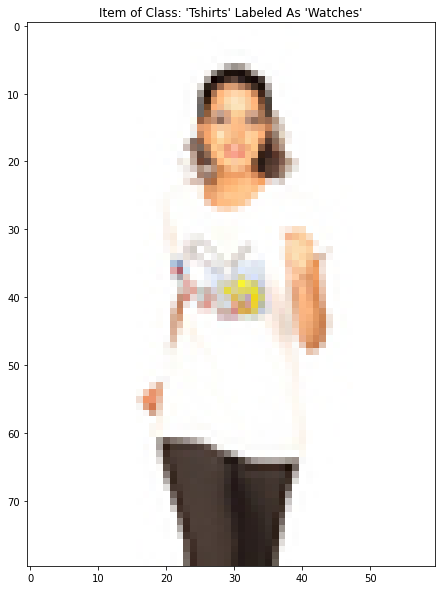

In [43]:
temp =misclassified_indexes[0]
img_rgb  = np.reshape(test_img[temp], newshape=(80,60,3))
plt.figure(figsize = (28,28))
f, axarr = plt.subplots(1,1, figsize=(10, 10))
title = "Item of Class: \'" +decipher_key[test_label[temp]] +"\' Labeled As \'"+decipher_key[y_pred[temp]]+"\'"
axarr.title.set_text(title)
axarr.imshow(img_rgb)

**It appers the white shirt is getting this image mislabeled**

**Pull Up Examples of False Positives (Watches as Tshirts)**

In [46]:
# Assuming y_true is your list of true labels and y_pred is your list of predicted labels
# And X_data is your original dataset

misclassified_indexes = []

for i in range(len(y_test)):
    # If true label is 'Tshirts' (which corresponds to 1)
    # and predicted label is 'Casual Shoes' (which corresponds to 3)
    if (y_test[i] == 2) and (y_pred[i] == 1):
        misclassified_indexes.append(i)

# Now, misclassified_indexes contains the indexes of all misclassified examples
# You can use it to get the corresponding data from X_data
#misclassified_data = x_test[misclassified_indexes]

<Figure size 2016x2016 with 0 Axes>

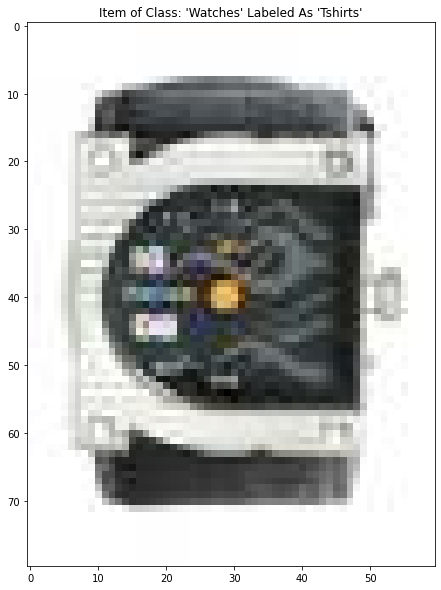

In [47]:
temp =misclassified_indexes[0]
img_rgb  = np.reshape(test_img[temp], newshape=(80,60,3))
plt.figure(figsize = (28,28))
f, axarr = plt.subplots(1,1, figsize=(10, 10))
title = "Item of Class: \'" +decipher_key[test_label[temp]] +"\' Labeled As \'"+decipher_key[y_pred[temp]]+"\'"
axarr.title.set_text(title)
axarr.imshow(img_rgb)

<Figure size 2016x2016 with 0 Axes>

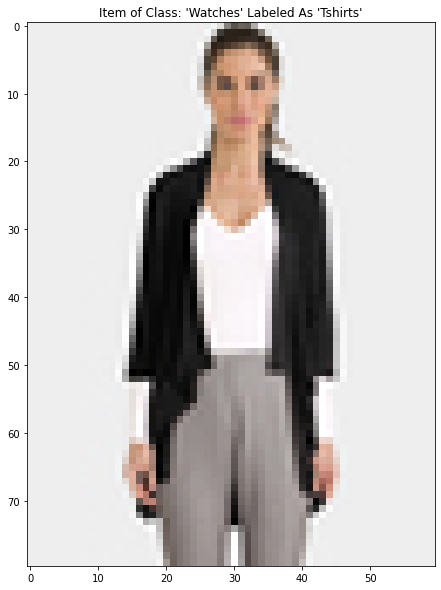

In [48]:
temp =misclassified_indexes[1]
img_rgb  = np.reshape(test_img[temp], newshape=(80,60,3))
plt.figure(figsize = (28,28))
f, axarr = plt.subplots(1,1, figsize=(10, 10))
title = "Item of Class: \'" +decipher_key[test_label[temp]] +"\' Labeled As \'"+decipher_key[y_pred[temp]]+"\'"
axarr.title.set_text(title)
axarr.imshow(img_rgb)

In [ ]:
temp =misclassified_indexes[2]
img_rgb  = np.reshape(test_img[temp], newshape=(80,60,3))
plt.figure(figsize = (28,28))
f, axarr = plt.subplots(1,1, figsize=(10, 10))
title = "Item of Class: \'" +decipher_key[test_label[temp]] +"\' Labeled As \'"+decipher_key[y_pred[temp]]+"\'"
axarr.title.set_text(title)
axarr.imshow(img_rgb)

**The above example shows that in the training data some of our Tshirt images are labeled as Watches.**

## Running Validation Data

**Load val data and form validation vectors**

In [13]:
# Load from file
with open('linear_svc_gray_small_histxy.pkl', 'rb') as f:
    clf_graw_loaded = pickle.load(f)

In [10]:
sumy_df =  pd.read_csv('histy_val.csv')
sumx_df =  pd.read_csv('histx_val.csv')
val_df = pd.read_csv('gray_small_val_set.csv')
val_hog_df = pd.read_csv('hog_fd_val.csv')




val_data = pd.concat([val_df, val_hog_df.iloc[:,1:], sumy_df.iloc[:,1:], sumx_df.iloc[:,1:]], axis=1)

x_val = val_data.iloc[:, 1:].values.astype(np.float32)
y_val =val_data['label'].values



# Load from file
with open('linear_svc_gray_small_histxy.pkl', 'rb') as f:
    clf_graw_loaded = pickle.load(f)

In [11]:
val_df.shape, val_hog_df.shape, sumy_df.shape, sumx_df.shape, val_data.shape, x_val.shape, y_val.shape

((483, 1201),
 (483, 1729),
 (483, 41),
 (483, 31),
 (483, 2999),
 (483, 2998),
 (483,))

In [14]:

percent=100
start_time = time.time()

print("Accuracy on the val set with gray plus HOG, and Sum of X and Y vector data: {:.3f}".format(clf_graw_loaded.score(x_val, y_val)))

print('percent complete: ',percent, end =" - %s seconds -\n" % \
              (time.time() - start_time), flush=False)


Accuracy on the val set with gray plus HOG, and Sum of X and Y vector data: 0.992
percent complete:  100 - 0.025018930435180664 seconds -


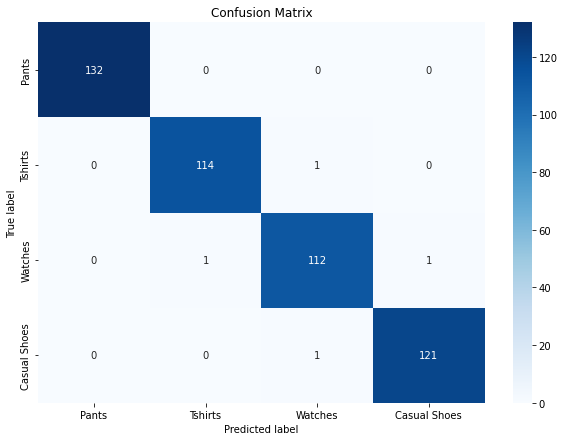

In [67]:
from sklearn.metrics import confusion_matrix
#x_tlist[i]
#y_tlist[i]

# Use the fitted model to make predictions on the same data used for fitting
y_pred = clf_graw_loaded.predict(x_val)

# Generate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

#print(cm)


# Create a heatmap
# Create a list of labels
labels = [decipher_key[i] for i in range(4)]
plt.figure(figsize=(10,7))
#sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add labels to the plot
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [68]:

# Assuming y_true is your list of true labels and y_pred is your list of predicted labels
# And X_data is your original dataset

misclassified_indexes = []

for i in range(len(y_val)):

    if (y_val[i] != y_pred[i]):
        misclassified_indexes.append(i)

# misclassified_indexes contains the indexes of all misclassified examples
# You can use it to get the corresponding data from X_data
#misclassified_data = x_test[misclassified_indexes]


misclassified_indexes

[20, 37, 51, 324]

In [69]:
val_df = pd.read_csv('output_rgb_val.csv')

#val_img = val_df.iloc[:, 1:].values.astype(np.float32)
val_img = val_df.iloc[:, 1:].values.astype(np.uint8)

val_label = val_df['label'].values

<Figure size 2016x2016 with 0 Axes>

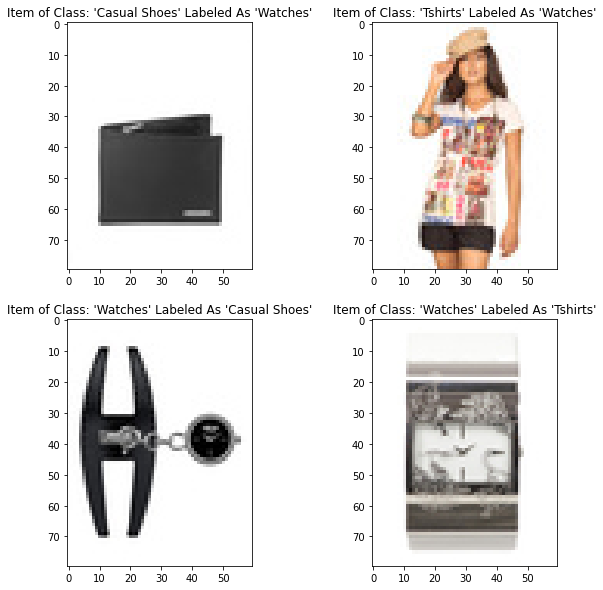

<Figure size 2016x2016 with 0 Axes>

<Figure size 2016x2016 with 0 Axes>

<Figure size 2016x2016 with 0 Axes>

In [70]:
temp = misclassified_indexes

img1  = np.reshape(val_img[temp[0]], newshape=(80,60,3))
plt.figure(figsize = (28,28))
f, axarr = plt.subplots(2,2, figsize=(10, 10))
title = "Item of Class: \'" + decipher_key[val_label[temp[0]]] +"\' Labeled As \'"+ decipher_key[y_pred[temp[0]]]+"\'"
axarr[0, 0].set_title(title)
axarr[0, 0].imshow(img1)


img2  = np.reshape(val_img[temp[1]], newshape=(80,60,3))
plt.figure(figsize = (28,28))
title = "Item of Class: \'" + decipher_key[val_label[temp[1]]] +"\' Labeled As \'"+ decipher_key[y_pred[temp[1]]]+"\'"
axarr[0, 1].set_title(title)
axarr[0, 1].imshow(img2)

img3  = np.reshape(val_img[temp[2]], newshape=(80,60,3))
plt.figure(figsize = (28,28))
title = "Item of Class: \'" + decipher_key[val_label[temp[2]]] +"\' Labeled As \'"+ decipher_key[y_pred[temp[2]]]+"\'"
axarr[1, 0].set_title(title)
axarr[1, 0].imshow(img3)

img4  = np.reshape(val_img[temp[3]], newshape=(80,60,3))
plt.figure(figsize = (28,28))
title = "Item of Class: \'" + decipher_key[val_label[temp[3]]] +"\' Labeled As \'"+ decipher_key[y_pred[temp[3]]]+"\'"
axarr[1, 1].set_title(title)
axarr[1, 1].imshow(img4)

## Hyperparameter Cross Validation 

In [71]:
# Get a list of all saved model files
model_files = [f for f in os.listdir() if f.startswith('linear_svc_gshh') and f.endswith('.joblib')]

# Initialize a list to store accuracy results
accuracy_results = []

# Loop over each file
for model_file in model_files:
    # Load the model from the file
    model = load(model_file)
    
    # Make predictions on the validation data
    y_pred = model.predict(x_val)
    
    # Calculate the accuracy
    accuracy = accuracy_score(y_val, y_pred)
    
    # Append the accuracy to the results list
    accuracy_results.append((model_file, accuracy))

# Convert the results to a DataFrame for pretty printing
df = pd.DataFrame(accuracy_results, columns=['Model', 'Accuracy'])

print(df)

                             Model  Accuracy
0  linear_svc_gshh_C_0.0001.joblib  0.991718
1   linear_svc_gshh_C_0.001.joblib  0.991718
2    linear_svc_gshh_C_0.01.joblib  0.989648
3     linear_svc_gshh_C_0.1.joblib  0.991718
4       linear_svc_gshh_C_1.joblib  0.991718
5      linear_svc_gshh_C_10.joblib  0.991718
6     linear_svc_gshh_C_100.joblib  0.991718
7    linear_svc_gshh_C_1000.joblib  0.991718
8   linear_svc_gshh_C_1e-05.joblib  0.991718
